$$
\begin{array}{c}
\textbf{CAUSAL INFERENCE - Fall 2025}\\\\
\textit{Center for Data Science, New York University} \\\\
\textit{November 7, 2025}\\\\\
\text{ Prepared by: Vivek Kumar Agarwal}\\\\
\textbf{Recitation 10: Instrumental Variables}\\\\
\end{array}
$$


![Causal Inference](../figures/CI_lab9_image1.png)

---

## Today's Recitation 

- Instrumental Variables (we will call them as - IV) 
- Lets Code!!

---

# Instrumental Variables

---

## Introduction: Where Does IV Fit?

### What We've Learned So Far

Let's review our toolkit for causal inference. 

**1. Randomized Experiments (The Gold Standard)**
- Random assignment makes treatment independent of potential outcomes
- Simple difference in means gives us the Average Treatment Effect (ATE)
- Example: LaLonde NSW jobs program
- **Works when:** We can randomize treatment

**2. Regression with Control Variables**
- If we measure all confounders, we can control for them
- Key assumption: *Conditional independence* - no unobserved confounding
- Example: Controlling for education and experience to isolate training effects
- **Works when:** We've measured everything that affects both treatment and outcome

---

### The Problem: What If We Can't Do Either?

In most real-world settings:
- We **cannot randomize** treatment (ethical, practical, or political constraints)
- We **cannot measure all confounders** (ability, motivation, family background often unobserved)

**Example:** Does education cause higher earnings?
- People with more education earn more
- But smarter, more motivated people get more education AND would earn more anyway
- Ability and motivation are largely unobserved
- Simple regression of earnings on education is **biased** (omitted variable bias)

---

### Enter next tool: Instrumental Variables

**The Core Idea:**
What if we could find something that creates *as-if random* variation in treatment, even though treatment itself isn't random?

**Instrumental Variables (IV) do exactly this:**
- Find a variable (the "instrument") that affects treatment
- But is unrelated to the unobserved confounders
- And only affects the outcome *through* treatment

**Think of it like:** Finding a "natural experiment" embedded in observational data

**Example Preview:** 
- Instrument: Distance to nearest college
- Treatment: Years of education
- Outcome: Earnings
- Logic: Distance affects education but doesn't directly affect ability or earnings (except through education)

---

In this lecture, we'll learn:
1. What makes a valid instrument
2. How IV estimation works (Two-Stage Least Squares)
3. What IV actually estimates (LATE)
4. When IV fails and how to diagnose problems

---

## The IV Framework: Setup and Assumptions

### The Problem We're Solving

**The Causal Question:**
We want to estimate the causal effect of treatment $S$ on outcome $Y$.

**The Challenge:**
- Treatment $S$ is correlated with unobserved factors $U$ that also affect $Y$
- Written formally: $S \not\!\perp\!\!\!\perp U$
- This means simple regression gives us **biased and inconsistent estimates**

**Example:**
- $S$ = years of education
- $Y$ = earnings
- $U$ = ability, motivation (unobserved)
- Problem: Smarter people get more education AND earn more anyway

### The IV Solution

**What is an Instrumental Variable?**

An instrument $Z$ is a variable that:
1. **Affects** the treatment variable $S$ (pushes people into or out of treatment)
2. Has **no direct effect** on outcome $Y$ (only affects $Y$ through $S$)
3. Is **independent** of unobserved confounders $U$

**The Key Insight:**
The instrument creates variation in $S$ that is **uncorrelated with $U$**, letting us isolate the causal effect.

**Visual Representation:**

<img src="https://raw.githubusercontent.com/dapivei/causal-infere/main/images/instrument.png" width="500"/>

**Interpretation of the diagram:**
- $Z$ affects $S$ (relevance)
- $Z$ does not directly affect $Y$ (exclusion restriction)
- $Z$ is independent of $U$ (exogeneity)

---

## The Three Key Assumptions

For $Z$ to be a valid instrument, we need:

### 1. Exogeneity (Independence)

**Statement:**
The instrument $Z$ must be uncorrelated with the error term $U$ and all unobserved confounders.

**Formally:** 
$$U \perp Z \quad \text{and} \quad V \perp Z$$

**What this means:**
- $Z$ is "as-if randomly assigned"
- $Z$ doesn't belong in the outcome equation
- This is the **exclusion restriction**: $Z$ only affects $Y$ through $S$

**Why it matters:**
If $Z$ is correlated with $U$, it's just as contaminated as $S$ - we haven't solved the problem!

**Example:**
- Distance to college should not be correlated with ability
- Distance might affect education, but shouldn't directly affect earnings

### 2. Relevance (First Stage)

**Statement:**
The instrument $Z$ must have a significant effect on treatment $S$.

**Formally:** 
$$S(Z=1, V) \neq S(Z=0, V)$$

**What this means:**
- Changing $Z$ actually changes treatment take-up
- There must be a "first stage" relationship between $Z$ and $S$

**Why it matters:**
If $Z$ doesn't affect $S$, it can't help us estimate anything!

**Example:**
- Distance to college must actually affect whether people attend college
- If everyone goes to college regardless of distance, distance is a weak instrument

### 3. Monotonicity (No Defiers)

**Statement:**
The instrument $Z$ must affect $S$ in the same direction for everyone.

**Formally:** 
$$S(Z=1, V) \geq S(Z=0, V) \text{ for all individuals}$$

**What this means:**
- $Z$ only increases (or only decreases) treatment likelihood
- No one does the opposite of what $Z$ suggests

**Why it matters:**
Allows us to interpret the IV estimate as an effect on a specific sub-population (compliers).

**Example:**
- Living closer to college makes everyone more likely (or no less likely) to attend
- No one avoids college *because* they live nearby

---

## Who Does IV Identify? The Four Types

The population divides into four groups based on how they respond to $Z$:

### 1. Always-Takers
- Always take treatment, regardless of $Z$
- $$S(Z=1, V) = S(Z=0, V) = 1$$
- **Example:** Would go to college even if they lived far away

### 2. Never-Takers
- Never take treatment, regardless of $Z$
- $$S(Z=1, V) = S(Z=0, V) = 0$$
- **Example:** Won't go to college even if they live next door

### 3. Compliers ⭐
- Treatment status changes with $Z$
- $$S(Z=1, V) = 1 \quad \text{and} \quad S(Z=0, V) = 0$$
- **Example:** Go to college if nearby, skip if far away
- **This is the group IV identifies**

### 4. Defiers (Ruled Out by Monotonicity)
- Do the opposite of what $Z$ suggests
- $$S(Z=1, V) = 0 \quad \text{and} \quad S(Z=0, V) = 1$$
- **Example:** Avoid college if nearby, attend if far away
- **Monotonicity assumes these don't exist**

---

## What IV Estimates: Local Average Treatment Effect (LATE)

### The Causal Model

We specify the outcome equation:
$$Y = \alpha_0 + \alpha_1 S + U$$

where:
- $\alpha_1$ = causal effect of $S$ on $Y$ (what we want!)
- $U$ = unobserved factors (the problem)

### The Wald Estimator

**Given:**
- $\mathbb{E}[U]=0$ (mean zero errors)
- $\mathbb{E}[ZU]=0$ (exogeneity)
- $\text{Cov}(Z,S)\neq 0$ (relevance)

**We can identify:**
$$\alpha_1^{IV} = \frac{\text{Cov}(Z,Y)}{\text{Cov}(Z,S)}$$

**For a binary instrument, this simplifies to:**
$$\alpha_1^{IV} = \frac{\mathbb{E}[Y | Z=1] - \mathbb{E}[Y | Z=0]}{\mathbb{E}[S | Z=1] - \mathbb{E}[S | Z=0]}$$

**Interpretation:**
- Numerator: Effect of instrument on outcome (reduced form)
- Denominator: Effect of instrument on treatment (first stage)
- Ratio: Effect of treatment on outcome

### What Does This Identify?

Under our assumptions, the Wald estimator gives us:

$$\alpha_{IV} = \mathbb{E}[Y(S=1,U)−Y(S=0,U) \mid \text{Complier}] = \text{LATE}$$

**Key Point:**
IV estimates the **Local Average Treatment Effect (LATE)** - the causal effect for **compliers only**, not the entire population.

**Why "Local"?**
- We only learn about people whose treatment status is affected by the instrument
- Always-takers and never-takers don't contribute to identification
- This is both a strength (we get a causal effect) and a limitation (only for compliers)

---

## Example: Does Sesame Street Improve Early Literacy?

### Research Question

> Does watching Sesame Street ($S$) have a positive impact on later academic achievement ($Y$)?

### Model Setup

$$
\begin{aligned}
S & =\left\{\begin{array}{l}
1 \text { if watched Sesame Street}  \\
0 \text { if did not watch Sesame Street}
\end{array}\right. \\
Y(S, U) & = \text{Score on a literacy test} \\
U & = \text{Other determinants of } Y
\end{aligned}
$$

where $U$ represents other determinants of $Y$, such as:
- Socio-economic status
- Parental education
- Home learning environment
- Baseline cognitive ability

### The Challenge: Omitted Variable Bias

**The Problem:**
$$S \not\!\perp\!\!\!\perp U$$

Various family and individual factors likely influence both:
- Whether a child watches the program ($S$), **and**
- The child's later academic outcomes ($Y$)

**Why this creates bias:**
- Children from educated families may be more likely to watch Sesame Street
- These same children may score higher on tests regardless of watching
- Simply comparing viewers to non-viewers confounds the effect of watching with family background

**Example of the bias:**
If we just computed $\mathbb{E}[Y|S=1] - \mathbb{E}[Y|S=0]$, we'd get:
- Viewers might score 80 on average
- Non-viewers might score 70 on average
- But this 10-point gap includes both:
  - The causal effect of Sesame Street, **and**
  - Selection bias from family differences

---

## The IV Solution: Encouragement Design

### The Instrument

Introduce an instrumental variable—**encouragement** $Z$—which we can control and randomize:

$$
Z =\left\{\begin{array}{l}
1 \text{ if encouraged to watch}  \\
0 \text{ if not encouraged}
\end{array}\right.
$$

**What is "encouragement"?**
- Provide families with additional information about Sesame Street
- Send promotional materials highlighting educational benefits
- Offer motivational support to increase viewing
- Based on Ball & Bogatz (1970) original study design

**Key feature:** Encouragement is **randomly assigned**, creating exogenous variation in viewing.

### Verifying the Three IV Assumptions

Let's check if encouragement $Z$ is a valid instrument:

#### 1. Exogeneity: $U \perp Z$

**Question:** Is encouragement independent of unobserved factors?

**Answer:** ✓ **Yes, because we randomly assigned it!**
- Random assignment ensures families with high $U$ are equally likely to be encouraged
- Encouragement status reveals nothing about socio-economic status, parental education, etc.
- This is the key advantage of an encouragement design

**Formal statement:**
$$\mathbb{E}[ZU] = 0$$

Encouragement does not belong in the outcome equation - it only affects test scores through watching.

#### 2. Relevance: Does $Z$ affect $S$?

**Question:** Does encouragement actually change viewing behavior?

**Answer:** This is an empirical question - we need to check!
- We expect: encouraged families are more likely to have their children watch
- But we need to verify there's a "first stage" relationship

**Formal statement:**
$$\mathbb{E}[S|Z=1] > \mathbb{E}[S|Z=0]$$

**How to check:** Run the first-stage regression and test if the coefficient is significant.

**Potential concern:** 
If encouragement doesn't change viewing (weak instrument), we can't learn anything.

#### 3. Monotonicity: No Defiers

**Question:** Does encouragement affect viewing in the same direction for everyone?

**Answer:** ✓ **Plausible assumption**
- Encouragement makes some families more likely to watch
- Hard to imagine families who would watch *unless* encouraged
- No obvious "defiers" in this context

**Formal statement:**
$$S(Z=1, V) \geq S(Z=0, V) \text{ for all families}$$

---

## The Four Types of Families

Not everyone responds to encouragement the same way. The population divides into four groups:

### 1. Always-Takers
- **Definition:** Watch Sesame Street regardless of encouragement
- **Example:** Enthusiastic families already committed to educational TV
- $$S(Z=1, V) = S(Z=0, V) = 1$$

### 2. Never-Takers  
- **Definition:** Don't watch Sesame Street regardless of encouragement
- **Example:** Families without TV access, or who prefer other programming
- $$S(Z=1, V) = S(Z=0, V) = 0$$

### 3. Compliers ⭐
- **Definition:** Watch if encouraged, don't watch if not encouraged
- **Example:** Families on the fence who respond to information
- $$S(Z=1, V) = 1 \quad \text{and} \quad S(Z=0, V) = 0$$
- **This is the group IV identifies!**

### 4. Defiers (Assumed Not to Exist)
- **Definition:** Watch if not encouraged, don't watch if encouraged
- **Example:** Contrarian families? (Hard to imagine in this context)
- $$S(Z=1, V) = 0 \quad \text{and} \quad S(Z=0, V) = 1$$
- **Ruled out by monotonicity assumption**

---

## What We're Estimating: LATE

### The Wald Estimator

With our IV, we can estimate:

$$\alpha_1^{IV} = \frac{\mathbb{E}[Y | Z=1] - \mathbb{E}[Y | Z=0]}{\mathbb{E}[S | Z=1] - \mathbb{E}[S | Z=0]}$$

**Interpretation:**
- **Numerator:** How much do test scores differ between encouraged vs. not encouraged?
- **Denominator:** How much does viewing differ between encouraged vs. not encouraged?
- **Ratio:** Effect of watching on test scores

### What Does This Estimate?

**Key point:** This gives us the **Local Average Treatment Effect (LATE)**

$$\alpha_{IV} = \mathbb{E}[Y(S=1,U) - Y(S=0,U) | \text{Complier}]$$

**In words:**
> The causal effect of watching Sesame Street on literacy scores, **for children whose viewing behavior is influenced by encouragement**.

**Who are we learning about?**
- ✓ **Compliers:** Marginal families who watch because encouraged
- ✗ **Not Always-takers:** They watch anyway
- ✗ **Not Never-takers:** They won't watch regardless

**Why "Local"?**
- The effect is "local" to compliers
- May differ from the effect for always-takers or never-takers
- This is both the strength (causal for someone) and limitation (not for everyone) of IV

### The Research Question (Revised)

Our IV allows us to answer:

> How does watching Sesame Street ($S$) impact academic achievement ($Y$) **for children whose likelihood of watching is influenced by encouragement** ($Z$)?

This is more specific than "what's the effect of Sesame Street?" but it's a causal effect we can credibly estimate!

## Lets code


### Data

- **`encour`**: Indicator variable for whether the child was encouraged to watch Sesame Stree. Instrument $Z$.
- **`watched`**: Indicator variable for whether the child actually watched Sesame Street. Treatment $S$.
- **`letters`**: Score on a literacy test. Outcome $Y$.
- **`age`**: Age of the child (in months), included as a control variable.
- **`female`**: Indicator variable for gender (female), included as a control variable.
- **`Other variables`**: Various additional factors.


In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np

from matplotlib.colors import LinearSegmentedColormap
from scipy import stats


sesame = pd.read_csv("../data/sesame.csv")
sesame.head()

,rownames,id,site,sex,age,viewcat,setting,viewenc,prebody,prelet,...,encour,_Isite_2,_Isite_3,_Isite_4,_Isite_5,regular,watched,encouraged,y,pretest
0,1,1,1,1,66,1,2,1,16,23,...,1,0,0,0,0,0,0,1,30,23
1,2,2,1,2,67,3,2,1,30,26,...,1,0,0,0,0,1,1,1,37,26
2,3,3,1,1,56,3,2,2,22,14,...,0,0,0,0,0,1,1,0,46,14
3,4,4,1,1,49,1,2,2,23,11,...,0,0,0,0,0,0,0,0,14,11
4,5,5,1,1,69,4,2,2,32,47,...,0,0,0,0,0,1,1,0,63,47


In [ ]:
#sesame.columns
sesame.describe()[['watched', 'encouraged']]

,watched,encouraged
count,240.000000,240.000000
mean,0.775000,0.633333
std,0.418455,0.482902
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


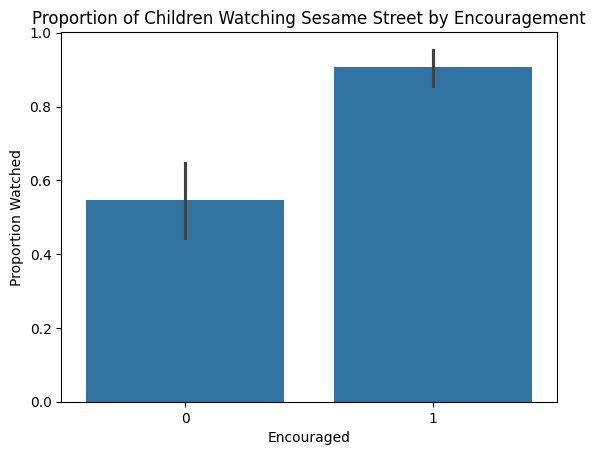

In [5]:
sns.barplot(x=sesame['encour'], y=sesame['watched'])
plt.title('Proportion of Children Watching Sesame Street by Encouragement')
plt.xlabel('Encouraged')
plt.ylabel('Proportion Watched')
plt.show()

- Plot shows that children who were encouraged to watch the show had a notably higher proportion of viewers compared to those who were not encouraged. 

- This difference suggests that ${\tt encouragement}$ effectively increases the likelihood of viewing Sesame Street.

### How plausible is ${\tt encouragement}$ as an instrument?

---


**Exogeneity**

We test whether encouragement is randomly assigned across relevant variables, ensuring balance between the encouraged and non-encouraged groups.

In [6]:
# List of variables to test for balance
variables_to_test = ['age', 'sex', 'pretest']

# Perform t-tests for each variable
for var in variables_to_test:

    # Split the data by encouragement status
    group_1 = sesame[sesame['encouraged'] == 1][var]
    group_0 = sesame[sesame['encouraged'] == 0][var]

    # Perform the t-test to compare means
    t_stat, p_value = stats.ttest_ind(group_1, group_0, equal_var=False)

    # Print results
    print(f'Test for {var}:')
    print(f'T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}')
    print('---')

    # Interpretation
    if p_value < 0.05:
        print(f"  Significant difference in {var}, suggests imbalance.\n")
    else:
        print(f"  No significant difference in {var}, supports balance.\n")


Test for age:
T-statistic: -0.3590, p-value: 0.7200
---
  No significant difference in age, supports balance.

Test for sex:
T-statistic: -0.3115, p-value: 0.7557
---
  No significant difference in sex, supports balance.

Test for pretest:
T-statistic: -1.4258, p-value: 0.1561
---
  No significant difference in pretest, supports balance.



---



**Relevance**

For the instrument to be relevant, it must be correlated with $S$ -- watching Sesame Street. Meaning that encouragement to watch Sesame Street has to actually make some kids more likely to watch it.

$$P(\text{Complier})>0 $$


If the encouragement has no effect—meaning kids are just as likely (or unlikely) to watch Sesame Street whether they’re encouraged or not—then encouragement isn’t a relevant instrument.

+ We test this using a linear regression model.


In [ ]:

model = smf.ols('watched ~ encouraged', data=sesame).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                watched   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     50.46
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           1.40e-11
Time:                        20:43:53   Log-Likelihood:                -107.88
No. Observations:                 240   AIC:                             219.8
Df Residuals:                     238   BIC:                             226.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5455      0.041     13.434      0.0

+ The coefficient is 0.3624, meaning that being encouraged to watch Sesame Street increases the likelihood of watching the program by approximately 36.24% compared to those who were not encouraged.
+ Statistical Significance: The p-value for encouraged is 0.000, which is highly significant. This suggests that the encouragement to watch Sesame Street has a statistically significant effect on the outcome.



---

**Monotonicity**

Monotonicity means that encouragement to watch Sesame Street should only make kids more likely to watch it—never less likely. So, kids encouraged to watch Sesame Street are either more likely to watch or at least equally likely, but encouragement never makes them watch less.

+ Perform logistic regression to check for monotonicity, which ensures that the instrument  does not induce defiers (children who behave contrary to encouragement):

$$P(\text{Defier})=0 $$

In [10]:
monotonicity_model = smf.logit('watched ~ encouraged + age + sex + site', data=sesame).fit()
print(monotonicity_model.summary())

Optimization terminated successfully.
         Current function value: 0.389264
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                watched   No. Observations:                  240
Model:                          Logit   Df Residuals:                      235
Method:                           MLE   Df Model:                            4
Date:                Thu, 06 Nov 2025   Pseudo R-squ.:                  0.2699
Time:                        20:46:14   Log-Likelihood:                -93.423
converged:                       True   LL-Null:                       -127.96
Covariance Type:            nonrobust   LLR p-value:                 3.564e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9288      1.841      1.048      0.295      -1.679       5.537
encouraged     2.5268      0.

+ Encouragement has a significant positive effect on the likelihood of watching Sesame Street ($p < 0.05$).

+ Age, sex, and site have less impact, which supports monotonicity.

Overall, our instrument seems pretty plausible!

#### Compliance Types


- **Compliers**: Watch Sesame Street only if encouraged.
- **Always-takers**: Watch Sesame Street regardless of encouragement.
- **Never-takers**: Do not watch Sesame Street regardless of encouragement.
- **Defiers**: Behave contrary to the encouragement (assumed to not exist due to monotonicity).

In [11]:
# Calculate proportions for each group
d_z_1 = sesame.loc[sesame['encour'] == 1, 'watched'].mean()
d_z_0 = sesame.loc[sesame['encour'] == 0, 'watched'].mean()

proportion_compliers = d_z_1 - d_z_0
proportion_always_takers = d_z_0
proportion_never_takers = 1 - d_z_1

# Assuming no Defiers
proportion_defiers = 0

In [12]:
proportion_compliers, proportion_always_takers, proportion_never_takers, proportion_defiers

(0.3624401913875599, 0.5454545454545454, 0.09210526315789469, 0)

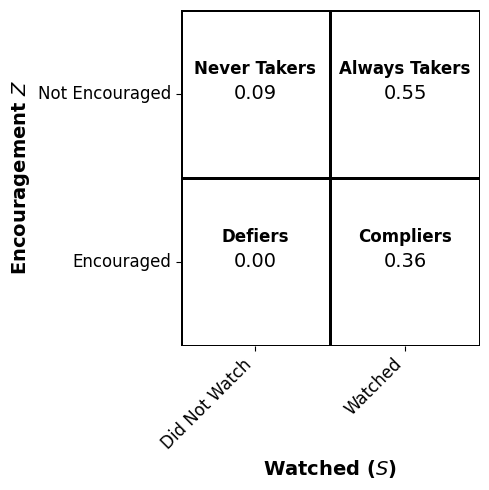

In [13]:
# Create the crosstab data directly
crosstab_data = pd.DataFrame({
    'Encouraged': ['Not Encouraged', 'Not Encouraged', 'Encouraged', 'Encouraged'],
    'Watched': ['Did Not Watch', 'Watched', 'Did Not Watch', 'Watched'],
    'Proportion': [proportion_never_takers, proportion_always_takers, proportion_defiers, proportion_compliers]
}).pivot(index='Encouraged', columns='Watched', values='Proportion')

# Reorder columns and index explicitly
crosstab_data = crosstab_data.reindex(index=['Not Encouraged', 'Encouraged'], columns=['Did Not Watch', 'Watched'])

# Define labels for each box
labels = {
    (0, 0): 'Never Takers',   # Not Encouraged, Did Not Watch
    (0, 1): 'Always Takers',        # Not Encouraged, Watched
    (1, 0): 'Defiers',  # Encouraged, Did Not Watch
    (1, 1): 'Compliers'       # Encouraged, Watched
}

# Plotting
plt.figure(figsize=(5, 5))
heatmap = sns.heatmap(
    crosstab_data,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='black',
    cbar=False,
    cmap=LinearSegmentedColormap.from_list('all_white', ['white', 'white']),
    annot_kws={"size": 14, "color": 'black'}
)

# Customizing the plot
plt.xlabel('Watched ($S$)', fontsize=14, fontweight='bold')
plt.ylabel('Encouragement $Z$', fontsize=14, fontweight='bold')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=12)

# Add custom labels
for (i, j), label in labels.items():
    plt.text(j + 0.5, i + 0.5 - 0.15, label, ha='center', va='center', fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.show()


### Estimating the LATE


#### Via the Wald Estimator


In [14]:
# Calculate covariance between Z (encouragement) and Y (outcome)
cov_zy = np.cov(sesame['encour'], sesame['y'])[0, 1]

# Calculate covariance between Z (encouragement) and S (watched Sesame Street)
cov_zs = np.cov(sesame['encour'], sesame['watched'])[0, 1]

# Calculate the Wald estimator (IV estimate)
alpha_1_IV = cov_zy / cov_zs
alpha_1_IV


7.93399339933995

In [15]:
# Calculate the means based on the value of the instrument Z (encouragement)
mean_y_z1 = sesame.loc[sesame['encour'] == 1, 'y'].mean()
mean_y_z0 = sesame.loc[sesame['encour'] == 0, 'y'].mean()
mean_s_z1 = sesame.loc[sesame['encour'] == 1, 'watched'].mean()
mean_s_z0 = sesame.loc[sesame['encour'] == 0, 'watched'].mean()

# Calculate the Wald estimator (IV estimate)
alpha_1_IV = (mean_y_z1 - mean_y_z0) / (mean_s_z1 - mean_s_z0)
alpha_1_IV


7.933993399339932

For those children who are encouraged to watch Sesame Street and actually end up watching it, their academic achievement (e.g., literacy scores) increases by 7.94 units on average.

---

## Calculating the IV Estimate: The Wald Estimator

We've just calculated the IV estimate two ways:

**Method 1: Difference in Means**
$$\alpha_1^{IV} = \frac{\mathbb{E}[Y | Z=1] - \mathbb{E}[Y | Z=0]}{\mathbb{E}[S | Z=1] - \mathbb{E}[S | Z=0]}$$

**Method 2: Covariance Formula**
$$\alpha_1^{IV} = \frac{\text{Cov}(Z,Y)}{\text{Cov}(Z,S)}$$

Both give us the same answer: **[7.94]**

This is the **Wald estimator** - it's simple and intuitive for our case.

---

## But What About Standard Errors?

**A problem:** 
We calculated the point estimate, but how do we know if it's statistically significant? We need **standard errors** to construct confidence intervals and test hypotheses!

**Another problem:**
What if we want to include **control variables** like age and sex? The simple Wald formula doesn't easily accommodate controls.

**Yet another problem:**
What if we had **multiple instruments**? The Wald estimator only works with one instrument at a time.

> We need a more **general framework** that:
> 1. Works with control variables
> 2. Handles multiple instruments  
> 3. Automatically computes correct standard errors
> 
> **Enter: Two-Stage Least Squares (2SLS)**

---

## Two-Stage Least Squares (2SLS): A General IV Framework

### The Core Idea

2SLS implements IV estimation through regression, making it easy to:
- Add control variables
- Use multiple instruments
- Get proper standard errors

**Key insight:** 
Instead of manually calculating covariances, we use regression to extract the "clean" variation in treatment.

### How 2SLS Works

**Stage 1: First Stage Regression**
Regress treatment on the instrument (and controls if any):
$$S = \gamma_0 + \gamma_1 Z + \text{controls} + \nu$$

This decomposes $S$ into:
- $\hat{S} = \gamma_0 + \gamma_1 Z + \ldots$ → variation predicted by $Z$ (clean!)
- $\nu$ → residual variation (potentially correlated with $U$)

**Stage 2: Second Stage Regression**
Regress outcome on the **predicted** treatment:
$$Y = \alpha_0 + \alpha_1 \hat{S} + \text{controls} + \varepsilon$$

This uses only the exogenous variation in $S$ (the part coming from $Z$).

### Why This Works

The predicted values $\hat{S}$ are:
- Only a function of the instrument $Z$ (and controls)
- Therefore uncorrelated with $U$ (since $Z \perp U$)
- Give us a "cleaned" version of treatment to use in the second stage

---


1. **First stage**: Regress whether children watched Sesame Street $S$ on the instrument $Z$ (whether they were encouraged to watch).
2. **Second stage**: Regress the outcome (e.g., academic performance $Y$) on the predicted values of $S$ from the first stage.

This method isolates the causal effect of watching Sesame Street on the outcome for **compliers** (those who watched due to encouragement).



In [16]:
first_stage = smf.ols('watched ~ encour', data=sesame).fit()
sesame['predicted_watched'] = first_stage.fittedvalues
second_stage = smf.ols('y ~ predicted_watched', data=sesame).fit()
late_2sls_manual = second_stage.params['predicted_watched']
late_2sls_manual

7.933993399339921

### "Reduced Form"

We can estimate the direct effect (ATE) of $Z$ on $Y$: how does the act of encouraging influence the later score performance?

This would be a valid causal estimate as the exogeneity assumption informs us of the independence assumption: $Z \perp U$.


In [17]:
smf.ols('y ~ encour', data=sesame).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.593
Date:                Thu, 06 Nov 2025   Prob (F-statistic):              0.109
Time:                        21:14:12   Log-Likelihood:                -961.16
No. Observations:                 240   AIC:                             1926.
Df Residuals:                     238   BIC:                             1933.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.9205      1.421     17.536      0.000      22.121      27.720
encour         2.8756      1.786      1.610      0.109      -0.642       6.393
==============================================================================
Omnibus:                       43.130   Durbin-Watson:                   1.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.314
Skew:                           0.535   Prob(JB):                     3.88e-05
Kurtosis:                       2.059   Cond. No.                         3.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The act of encouraging kids to watch Sesame Street has a nearly 3-point increase in their test scores! (though the p-value is not particularly small)

#### Remember non-compliance and ITT?

We can re-interpret this setup as the old ATE estimation problem. The treatment of interest, in this case, watching Sesame, cannot be enforced. We can randomize who are asked to watch Sesame Street, but there will be the non-compliance issue that prevents us from deriving ATE (given the always-takers and never-takers).

We have learned that we can change the causal question when there is non-compliance from ATE to Intent-to-Treat (ITT) effect.


The ITT estimates the causal effect of *treatment assignment* on the outcome of interest. Here, the ITT estimates the causal effect of being encouraged to watch Sesame Street on a child’s score on the literacy test.

Hence, the *treatment assignment* can also be framed as an instrumental variable. The direct effect we obtained above can also be thought of as being a ITT estimate.

### Weak Instrument

---

For **exogeneity**, we can check for the distribution balance for some control variables across different values of instrument $Z$.

For **relevance**, in general, we can check the relationship between $S$ and $Z$. One approach is to look at the first-stage regression.

For **monotonicity**, this assumption is technically untestable. For example, we want to understand whether there are defilers or not in our data. However, we do not observe the counterfactual outcome for each individual (fundamental problem of causal inference). We can still reason about monotonicity based on previous evidence and assess whether this will likely be true for specific problem setup.

---

In particular, the ***weak instrument*** problem relates to the **relevance** assumption.

For the instrument to be relevant, it must be correlated with $S$ -- watching Sesame Street. Meaning that encouragement to watch Sesame Street has to actually make some kids more likely to watch it.

$$P(\text{Complier})>0 $$


We only require the proportion of compliers to be greater than $0$. This will still be true when the number is small or close to $0$, which gives us a weak instrument. It will blow up our estimator as the denominator of Cov$(S, Z)$ is small.

Similarly, we can test this with first-stage linear regression of the following form:
$$
S = \beta_0 + \beta_1 Z
$$
Once we fit the model, we can check for the F-statistic or t-statistic as we only have one independent variable in this regression.

In [18]:
smf.ols('watched ~ encour', data=sesame).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                watched   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     50.46
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           1.40e-11
Time:                        21:17:41   Log-Likelihood:                -107.88
No. Observations:                 240   AIC:                             219.8
Df Residuals:                     238   BIC:                             226.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5455      0.041     13.434      0.000       0.465       0.625
encour         0.3624      0.051      7.104      0.000       0.262       0.463
==============================================================================
Omnibus:                       28.214   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.601
Skew:                          -0.943   Prob(JB):                     1.86e-08
Kurtosis:                       3.042   Cond. No.                         3.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficient is 0.3624, meaning that being encouraged to watch Sesame Street increases the likelihood of watching the program by approximately 36.24% compared to those who were not encouraged.


The F-statistic is 50.46 which is more than the threshold 10 presented in the lecture.

Both p-values for the F/t-statistic are extremely small. Hence, we do not have a weak instrument problem here.



### Estimation

We saw that we can estimate using the covariance functions as well as running two-stage squares.

A more direct method is to call `IV2SLS` from `linearmodels` package.



#### Via the (explicit) Two-Stage Least Squares (2SLS) Estimation



1. **First stage**: Regress whether children watched Sesame Street $S$ on the instrument $Z$ (whether they were encouraged to watch).
2. **Second stage**: Regress the outcome (e.g., academic performance $Y$) on the predicted values of $S$ from the first stage.

This method isolates the causal effect of watching Sesame Street on the outcome for **compliers** (those who watched due to encouragement).



In [19]:
first_stage = smf.ols('watched ~ encour', data=sesame).fit()
sesame['predicted_watched'] = first_stage.fittedvalues
second_stage = smf.ols('y ~ predicted_watched', data=sesame).fit()
late_2sls_manual = second_stage.params['predicted_watched']
late_2sls_manual

7.933993399339921

#### Via the IV2SLS Function from linearmodels

In [21]:
import linearmodels as lm

lm.IV2SLS.from_formula('y ~ 1 + [watched ~ encour]', data=sesame).fit().summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      y   R-squared:                      0.1355
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1318
No. Observations:                 240   F-statistic:                    2.9570
Date:                Thu, Nov 06 2025   P-value (F-stat)                0.0855
Time:                        21:22:00   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      20.593     3.6811     5.5942     0.0000      13.378      27.808
watched        7.9340     4.6138     1.7196     0.0855     -1.1090      16.977
==============================================================================

Endogenous: watched
Instruments: encour
Robust Covariance (Heteroskedastic)
Debiased: False
"""

### Instrument with Control

If we have extra observed characteristics, we can control them as part of the IV procedure.

This could potentially make the exogeneity argument stronger via conditional independence.

$$
Z \perp U | C
$$

However, this will impact the parameter estimate as we saw in regression with control. The weights for each controlled subgroup will change to the covariance of $Z$ and $S$ in that group.

$$
\alpha_1^{\text{IV, Cont.}} = E \left[ \frac{\text{Cov}(Z, S | C = c)}{\text{Cov}(Z, S)} \text{LATE}(C = c) \right]
$$

Let's try controlling for two variables `age` and `sex`.


In [22]:
first_stage = smf.ols('watched ~ encour + age + sex', data=sesame).fit()
sesame['predicted_watched'] = first_stage.fittedvalues
second_stage = smf.ols('y ~ predicted_watched + age + sex', data=sesame).fit()
late_2sls_manual = second_stage.params['predicted_watched']
late_2sls_manual

8.482026098072685

In [23]:
# direct method
lm.IV2SLS.from_formula('y ~ 1 + age + sex + [watched ~ encour]', data=sesame).fit().summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      y   R-squared:                      0.2077
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1976
No. Observations:                 240   F-statistic:                    25.201
Date:                Thu, Nov 06 2025   P-value (F-stat)                0.0000
Time:                        21:27:59   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -10.571     7.6520    -1.3814     0.1671     -25.568      4.4270
age            0.5505     0.1190     4.6241     0.0000      0.3172      0.7838
sex            1.5620     1.5530     1.0058     0.3145     -1.4818      4.6058
watched        8.4820     4.3245     1.9614     0.0498      0.0062      16.958
==============================================================================

Endogenous: watched
Instruments: encour
Robust Covariance (Heteroskedastic)
Debiased: False
"""

## Colider Bias

Besides complicated interpretations, controlling for more variables can also get us in trouble due to colider bias.

In previous labs, we covered a brief overview of different types of conditional independence structures.


![Indep](https://catalogofbias.org/wp-content/uploads/sites/2/2019/03/Collider-bias_fig-1-e1551439537528.png)

**Collider bias** occurs when two variables independently influence a third variable (called a collider), and we condition on or control for this collider (or its descedents).

This conditioning can induce a spurious association between the two independent variables, leading to incorrect conclusions about their relationship. What are some real-life examples?

In [24]:
np.random.seed(42)  # For reproducibility

N = 10000  # Sample size
S = np.random.normal(0, 1, N)
Y = np.random.normal(0, 1, N)

noise = np.random.normal(0, 1, N)
C = 2 * S + 2 * Y + noise

data = pd.DataFrame({'S': S, 'Y': Y, 'C': C})

For simplicity, we will not introduce any dependence between $S$ and $Y$ to demonstrate how conditioning on $C$ creates dependence from 0.

In practice, $S$ does influence $Y$ directly, which is the direct causal effect of interest. Conditioning on $C$ will bias the effect with extra dependence.

In [25]:
corr_full = data['S'].corr(data['Y'])
print(f"Correlation between S and Y in the full dataset: {corr_full:.4f}")

Correlation between S and Y in the full dataset: -0.0086


In [26]:
threshold = np.percentile(data['C'], 90)
data_conditioned = data[data['C'] > threshold]

corr_conditioned = data_conditioned['S'].corr(data_conditioned['Y'])
print(f"Correlation between S and Y after conditioning on C: {corr_conditioned:.4f}")

Correlation between S and Y after conditioning on C: -0.6000


This negative correlation indicates that X and Y are now dependent after conditioning on Z, demonstrating collider bias.

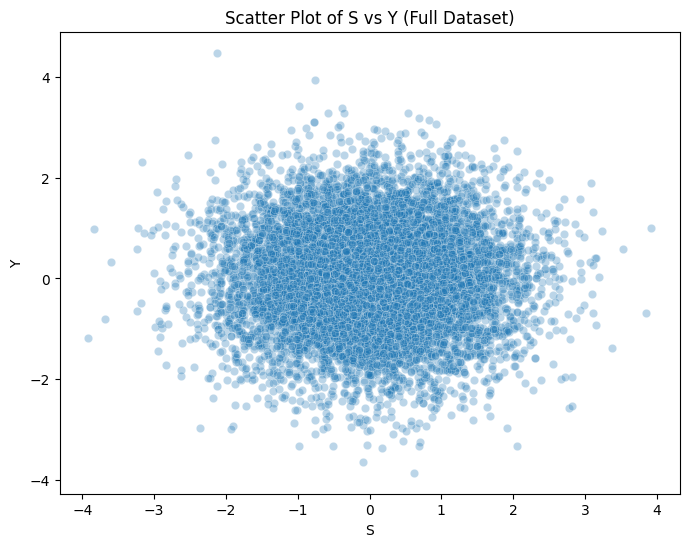

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='S', y='Y', data=data, alpha=0.3)
plt.title('Scatter Plot of S vs Y (Full Dataset)')
plt.show()

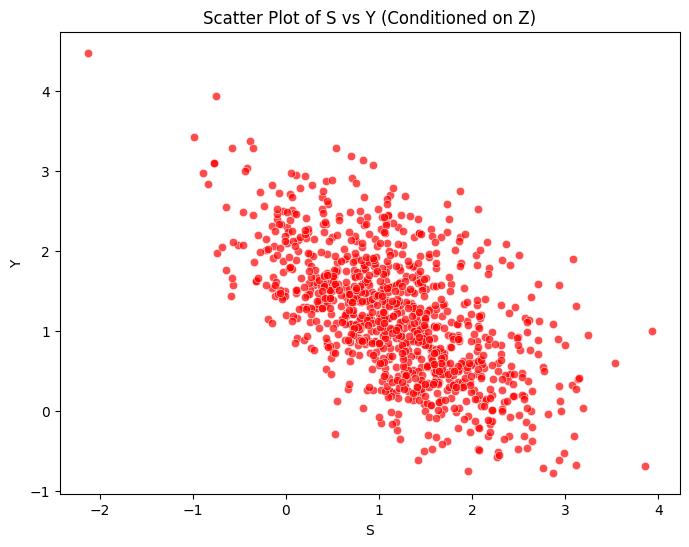

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='S', y='Y', data=data_conditioned, color='red', alpha=0.7)
plt.title('Scatter Plot of S vs Y (Conditioned on Z)')
plt.show()

We should be careful about which variables to control and reason about them based on the problem context to avoid additional bias.

---